In this notebook, I will use torch_geometric to predict the developpement of a graph of positions through time

In [1]:
"""
I realized I am leaning towards this approach https://doi.org/10.1016/j.trc.2020.102635
"""

'\nI realized I am leaning towards this approach https://doi.org/10.1016/j.trc.2020.102635\n'

In [1]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import pickle

import sys
import os
from genericpath import exists

from cell_dataset import CellGraphDataset, load, single_overfit_dataset
from cell_model import GraphEvolution, GraphEvolutionDiscr
from cell_utils import GraphingLoss, make_animation
from cell_training import train, test_single, compute_parameters, run_single_recursive

import matplotlib.pyplot as plt

import os, psutil
process = psutil.Process(os.getpid())
print("Using : ", process.memory_info().rss // 1000000)  # in megabytes 
print("Available : ", process.memory_info().vms  // 1000000)  # in megabytes 

print(torch.cuda.is_available())

#https://github.com/clovaai/AdamP
from adamp import AdamP

sys.path.append('/home/nstillman/1_sbi_activematter/cpp_model')
try :
    import allium
except :
    print("Could not import allium")

c:\Users\gille\miniconda3\envs\geom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using :  293
Available :  3271
True
Could not import allium


The data is a graph of cells having their own positions and velocity.

In the graph, we will first start by connecting all the edges, then maybe later make radius_graphs to reduce the cost of the pass through the model

In [2]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

extension = "_open_lt_hv"
number_of_messages = 2
size_of_messages = 64
absolute = 0
epochs = 160

model_path = "models/model" + extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative")
loss_path = "models/loss" + extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative")

data_train, data_test, data_val = load(load_all, extension, pre_separated, override)

Validation data not found


In [4]:
#INFO : if bg_load is True, this starts the loading, if skipped, bg_loading will take place as soon as a get is called
rval, edge_index, edge_attr, border, params = data_train.get(0)
rval, edge_index, edge_attr, border, params = data_test.get(0)

print("Is data wrapped ? ", data_train.wrap)

Is data wrapped ?  False


Next we need to define the model that will be used :
    > input 
        (1) Graph at a particular time t (nodes having x,y,dx,dy as attributes)
        (2) Graphs up to a particular time [t-a, t] (nodes having x,y as attributes)
    > output
        (a) Graph at the immediate next time step t+1
        (b) Graph [t, t+b]
        (c) Graph at t+b
    > graph size
        (x) Fixed graph size to the most nodes possible (or above)
        (y) Unbounded graph size
            >> idea : graph walks
            >> idea : sampler

The following model will do (1ax)

In [5]:
def start(model : GraphEvolution, optimizer : torch.optim.Optimizer, scheduler  : torch.optim.lr_scheduler._LRScheduler,\
          data_train : CellGraphDataset, data_test : CellGraphDataset, device : torch.device, epoch : int, offset : int, grapher : GraphingLoss, save=0, save_datasets=True):
    
    loss_history_train = {"loss_mean" : [], "loss_log" : [], "loss" : []}
    loss_history_test_recursive = {"loss_mean" : [], "loss_log" : [], "loss" : []}
    loss_history_test_single = {"loss_mean" : [], "loss_log" : [], "loss" : []}
    for e in range(offset, offset + epoch):
        
        recursive = epoch > 10

        train(model, optimizer, scheduler, data_train, device, e, process, max_epoch=offset+epoch, loss_history = loss_history_train, recursive=recursive)

        #model.show_gradients()
        
        if(e == 0 and save_datasets) :
            data_train.thread = None
            data_test.thread = None
            with open("data/training" + extension + ".pkl", 'wb') as f:
                pickle.dump(data_train, f)
            with open("data/testing" + extension + ".pkl", 'wb') as f:
                pickle.dump(data_test, f)
            print("Saved datasets")
        

        test_loss_s = test_single(model, data_test, device, loss_history_test_recursive, duration=16, recursive=False)
        test_loss_r = test_single(model, data_test, device, loss_history_test_single, duration=16, recursive=True)

        print("Epoch : ", e, "Test loss : ", test_loss_s, "Test loss recursive : ", test_loss_r)


        grapher.plot_losses(title="Training", data=loss_history_train, extension=extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative") + "_") 
        grapher.plot_losses(title="Testing", data=loss_history_test_recursive, extension=extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative") + "_") 
        grapher.plot_losses(title="Testing recursive", data=loss_history_test_single, extension=extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative") + "_") 
        
        if (e%save == 0) :      
            all_params_out, all_params_true = compute_parameters(model, data_test, device, duration=-1)
            grapher.plot_params(all_params_out, all_params_true, e, extension=extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative"))
        
        if (save and (e%save == 0 or e == epoch-1)) :
            torch.save(model.state_dict(), model_path + str(e) + ".pt")

In [3]:
load = True

epoch_to_load = 100

model = GraphEvolution(in_channels=14, out_channels=4, hidden_channels=size_of_messages, dropout=0.05, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, absolute=absolute)
#model = GraphEvolution(in_channels=9, out_channels=4, hidden_channels=32, dropout=0.01, edge_dim=2, messages=5, wrap=True)
#model = GraphEvolutionDiscr(in_channels=9, out_channels=4, hidden_channels=16, dropout=0.01, edge_dim=2, messages=5, wrap=True)

if exists(model_path + str(epoch_to_load) + ".pt") and load :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")

Loaded model


In [4]:
#might want to investigate AdamP 
optimizer = AdamP(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-0, weight_decay=5e-3, delta=0.1, wd_ratio=0.1, nesterov=True)
scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, T_mult=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
grapher = GraphingLoss()

model = model.to(device)

#all_params_out, all_params_true = compute_parameters(model.to(device), data_test, device, duration=0)
#grapher.plot_params(all_params_out, all_params_true, epoch_to_load, extension=extension)

In [9]:
start(model, optimizer, scheduler, data_train, data_test, device, \
        epochs, epoch_to_load, grapher=grapher, save=100, save_datasets=False)

Epoch :  0 Test loss :  0.8968114930391312 Test loss recursive :  12.359140548706055
Epoch :  1 Test loss :  0.8488066601753235 Test loss recursive :  13.089103775024414
Epoch :  2 Test loss :  0.7289852875471116 Test loss recursive :  15.040167455673219
Epoch :  3 Test loss :  0.5112697660923005 Test loss recursive :  20.751862773895265
Epoch :  4 Test loss :  0.47903104186058043 Test loss recursive :  23.111919269561767
Epoch :  5 Test loss :  0.8171311968564987 Test loss recursive :  10.87801082611084
Epoch :  6 Test loss :  0.8213048636913299 Test loss recursive :  10.651217889785766
Epoch :  7 Test loss :  0.8202185863256455 Test loss recursive :  10.951782236099243
Epoch :  8 Test loss :  0.7845721650123596 Test loss recursive :  11.88713062286377
Epoch :  9 Test loss :  0.8165939599275589 Test loss recursive :  10.26571530342102
Epoch :  10 Test loss :  1.047590582370758 Test loss recursive :  6.689527525901794
Epoch :  11 Test loss :  1.0612707018852234 Test loss recursive :  6

In [6]:
epochs = 101

In [ ]:
all_params_out, all_params_true = compute_parameters(model, data_test, device, duration=-1)
grapher.plot_params(all_params_out, all_params_true, epochs - 1, extension=extension)

torch.Size([98, 100, 2])
torch.Size([98, 100, 2])


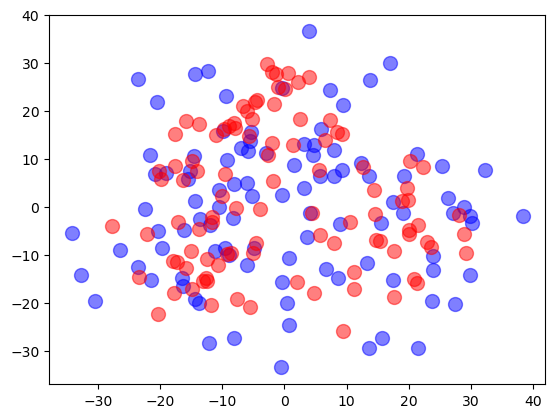

In [7]:
loss_history = {'loss_mean' : [], 'loss_log' : [], 'loss' : []}
loss, out, x = run_single_recursive(model, data_test, 0, device, loss_history, output=True)

if x == None or out == None :
    print("No output")
    exit()

#make x the size of the output
x = x[:out.shape[0], :out.shape[1], :out.shape[2]]

out = out.detach().cpu().numpy()
x = x.detach().cpu().numpy()


result_name = "models/result_recursive" + extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + str(epochs-1) + ".pkl"

with open(result_name, "wb") as f:
    pickle.dump((out, x), f)

t = 10
fig = plt.figure()

#now plot the graph as bubbles to show the difference between the two
plt.scatter(x[t, :,0],x[t, :,1], s=100, c='b', alpha=0.5)
plt.scatter(out[t, :,0],out[t, :,1], s=100, c='r', alpha=0.5)

plt.show()
plt.close()

animation_name = "models/animation_recursive" + extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + str(epochs-1) + ".mp4"
make_animation(result_name, animation_name, show_speed=False)
